## Assigment 3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from os import walk
from a3_utils import draw_line

In [2]:
def readGrayF64(path):
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float64) / 255

### Exercise 1

#### A

- Ix (x,y) = [g(y) * I(x, y)] * dg(x) / dx
- Iy (x, y) = [g(x) * I(x, y)] * dg(y) / dy
- Ixx (x, y) = [g(y) * Ix (x, y)] * dg(x) / dx
- Iyy (x, y) = [g(x) * Iy(x, y)] * dg(y) / dy
- Ixy (x, y) = [g(x) * Ix (x, y)] * dg(y) / dy
- Iyx (x, y) = [g(y) * Iy (x,y)] * dg(x) / dx

#### B

In [3]:
def gaussdx(sigma):
    f = lambda x: np.exp(-x**2/(2*sigma**2)) * (-x/(np.sqrt(2*np.pi) * sigma**3))
    r = np.array(list(map(f, np.arange(-3*sigma, 3*sigma+1))))
    return (r / sum(abs(r))).reshape(1, r.shape[0])

def gaussian(sigma):
    f = lambda x: np.exp(-x**2/(2*sigma**2)) / (np.sqrt(2*np.pi) * sigma)
    r = np.array(list(map(f, np.arange(-3*sigma, 3*sigma+1))))
    return (r / sum(r)).reshape(1, r.shape[0])

In [4]:
g = gaussian(2)
print("Sum:", np.sum(g))
print("Abs Sum:", np.sum(abs(g)))
g[0, :]

Sum: 0.9999999999999999
Abs Sum: 0.9999999999999999


array([0.0022182 , 0.00877313, 0.02702316, 0.06482519, 0.12110939,
       0.17621312, 0.19967563, 0.17621312, 0.12110939, 0.06482519,
       0.02702316, 0.00877313, 0.0022182 ])

In [5]:
gdx = -gaussdx(2)
print("Sum:", np.sum(gdx))
print("Abs Sum:", np.sum(abs(gdx)))
gdx[0, :]

Sum: 3.469446951953614e-18
Abs Sum: 1.0000000000000002


array([-0.00855153, -0.02818497, -0.06945265, -0.12495619, -0.1556326 ,
       -0.11322205, -0.        ,  0.11322205,  0.1556326 ,  0.12495619,
        0.06945265,  0.02818497,  0.00855153])

#### C

In [6]:
impulse = np.zeros((51, 51))
impulse[25, 25] = 1

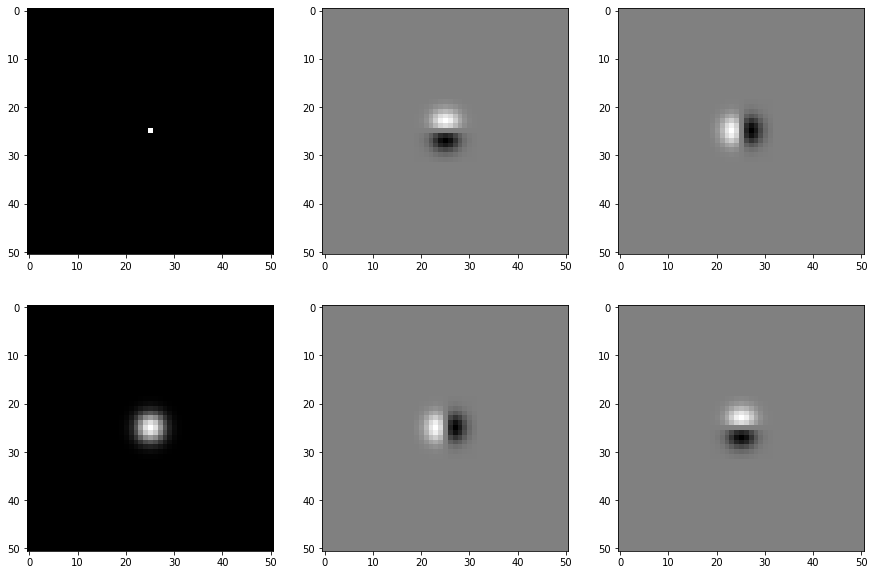

In [7]:
kernels =   [[      None,   (g, gdx.T), (gdx, g.T)  ],
            [   (g.T, g),   (g.T, gdx), (gdx.T, g)  ]]

figure, axes = plt.subplots(2, 3, figsize=(15, 10))
for i in range(len(axes)):
    for j in range(len(axes[i])):
        img = impulse.copy()
        if kernels[i][j] is not None:
            img = cv2.filter2D(img, -1, kernel=kernels[i][j][0])
            img = cv2.filter2D(img, -1, kernel=kernels[i][j][1])
        axes[i][j].imshow(img, cmap='gray')


#### D

In [8]:
def imgDX(I):
    return cv2.filter2D(cv2.filter2D(I, -1, kernel=g.T), -1, kernel=gdx)

def imgDY(I):
    return cv2.filter2D(cv2.filter2D(I, -1, kernel=g), -1, kernel=gdx.T)

def imgDXX(I):
    return imgDX(imgDX(I))

def imgDXY(I):
    return imgDY(imgDX(I))

def imgDYX(I):
    return imgDX(imgDY(I))

def imgDYY(I):
    return imgDY(imgDY(I))


In [9]:
def gradient_magnitude(I):
    magnitude = np.sqrt(imgDX(I)**2 + imgDY(I)**2)
    angle = np.arctan2(imgDY(I), imgDX(I))
    return magnitude, angle

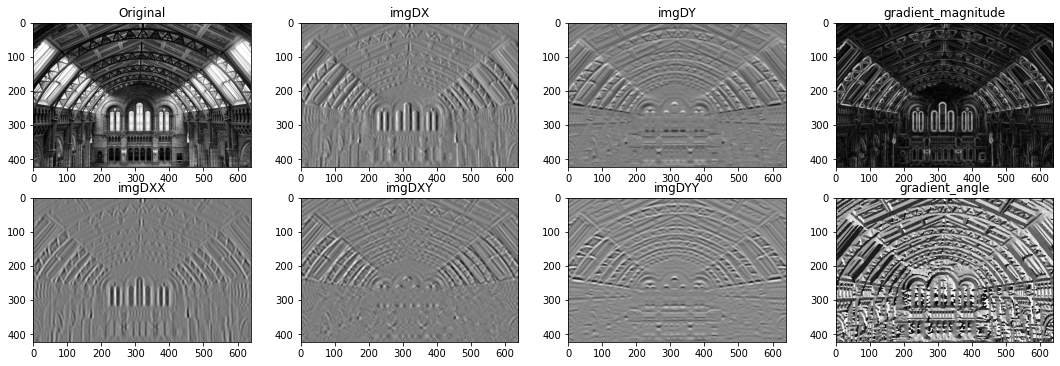

In [10]:
original = readGrayF64('./assigments/assigment3/images/museum.jpg')

fig, axes = plt.subplots(2, 4, figsize=(15, 5))
fig.tight_layout(pad=1.0)

axes[0, 0].imshow(original, cmap='gray')
axes[0, 0].set_title('Original')

axes[0, 1].imshow(imgDX(original), cmap='gray')
axes[0, 1].set_title('imgDX')

axes[0, 2].imshow(imgDY(original), cmap='gray')
axes[0, 2].set_title('imgDY')

axes[0, 3].imshow(gradient_magnitude(original)[0], cmap='gray')
axes[0, 3].set_title('gradient_magnitude')

axes[1, 0].imshow(imgDXX(original), cmap='gray')
axes[1, 0].set_title('imgDXX')

axes[1, 1].imshow(imgDXY(original), cmap='gray')
axes[1, 1].set_title('imgDXY')

axes[1, 2].imshow(imgDYY(original), cmap='gray')
axes[1, 2].set_title('imgDYY')

axes[1, 3].imshow(gradient_magnitude(original)[1], cmap='gray')
axes[1, 3].set_title('gradient_angle')

pass

#### E

In [11]:
def hist(angle, magnitude, bins=8):
    h = np.zeros(bins)
    for i in range(angle.shape[0]):
        for j in range(angle.shape[1]):
            idx = int((angle[i, j] + np.pi) * bins / (2 * np.pi))
            h[min(idx, len(h) -1)] += magnitude[i, j]
    return h

def img_hist(I, grid=(8, 8), bins=8):
    h, w = I.shape
    magnitude, angle = gradient_magnitude(I)
    step_h = h // grid[0]
    step_w = w // grid[1]

    hist_img = []
    for i in range(0, h, step_h):
        for j in range(0, w, step_w):
            section_angels = angle[i:i+step_h, j:j+step_w]
            section_magnitude = magnitude[i:i+step_h, j:j+step_w]
            hist_img.extend(hist(section_angels, section_magnitude, bins=bins))
    return np.array(hist_img) / np.sum(hist_img)
    
def chi_square_distance(hist_A, hist_B, e=10**-10):
    return 0.5 * np.sum((hist_A - hist_B) ** 2 / (hist_A + hist_B + e))

In [12]:
directory = "./assigments/assigment2/dataset/"
images = [readGrayF64(directory + f) for f in next(walk(directory))[2]]


In [13]:
histograms = [img_hist(img) for img in images]

In [14]:
N = 0
selected = images[N]
distances = [chi_square_distance(histograms[N], hist) for hist in histograms]
most_similar = np.argsort(distances)

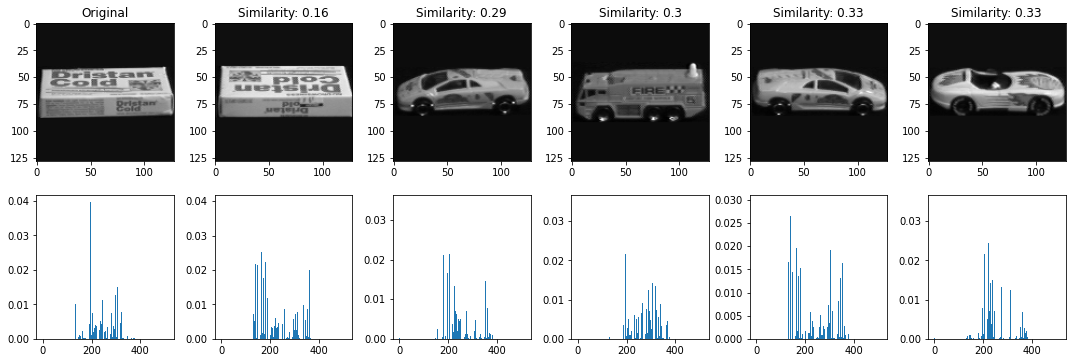

In [15]:
show_n_most_similar = 5
fig, axes = plt.subplots(2, show_n_most_similar + 1, figsize=(15, 5))
fig.tight_layout(pad=1.0)

axes[0, 0].imshow(selected, cmap='gray')
axes[0, 0].set_title('Original')

axes[1, 0].bar(range(len(histograms[N])), histograms[N])

for i in range(show_n_most_similar):
    axes[0, i+1].imshow(images[most_similar[i +1]], cmap='gray')
    axes[0, i+1].set_title('Similarity: ' + str(round(distances[most_similar[i +1]], 2)))

for i in range(show_n_most_similar):
    axes[1, i +1].bar(range(len(histograms[most_similar[i +1]])), histograms[most_similar[i +1]])

### Exercise 2

#### A

In [16]:
def magnitude_edges(Imag, theta):
    Ie = Imag.copy()
    Ie[Imag < theta] = 0
    return Ie

In [17]:
museum = readGrayF64("./assigments/assigment3/images/museum.jpg")
museum_mag, museum_angles = gradient_magnitude(museum)
print(museum_mag.min(), museum_mag.max())
print(museum_angles.min(), museum_angles.max())

1.371419323662774e-18 0.4495631248993536
-3.141592653589793 3.141592653589793


In [18]:
museum_edges = magnitude_edges(museum_mag, 0.1)

Text(0.5, 1.0, 'theta=40')

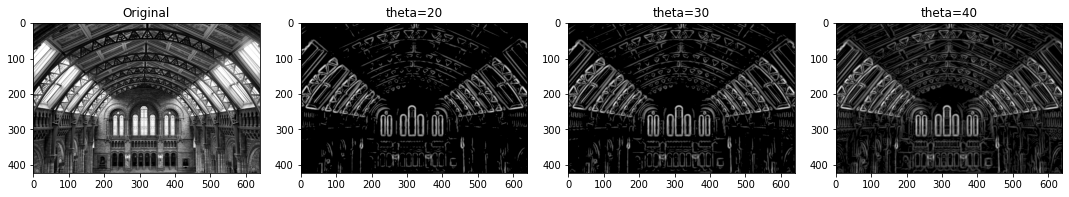

In [19]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
fig.tight_layout(pad=1.0)

axes[0].imshow(museum, cmap='gray')
axes[0].set_title('Original')

axes[1].imshow(museum_edges, cmap='gray')
axes[1].set_title('theta=20')

axes[2].imshow(magnitude_edges(museum_mag, 0.08), cmap='gray')
axes[2].set_title('theta=30')

axes[3].imshow(magnitude_edges(museum_mag, 0.04), cmap='gray')
axes[3].set_title('theta=40')

#### B

In [20]:

def non_maxima_suppression(rough_edges, magnitude, angles):
    edges = rough_edges.copy()
    discrete_angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    directions = [[(0, 1), (0, -1)], [(1, 1), (-1, -1)], [(1, 0), (-1, 0)], [(1, -1), (-1, 1)]]
    for i in range(1, edges.shape[0] - 1):
        for j in range(1, edges.shape[1] - 1):
            if edges[i, j] == 0:
                continue

            aprox_direction = np.argmin(np.abs(discrete_angles - (angles[i, j] + np.pi)))
            d = directions[aprox_direction]
            
            if magnitude[i, j] < np.max([magnitude[(i + di, j + dj)] for di, dj in d]):
                edges[i, j] = 0
    return edges

def magnitude_edges_nms(Imag, Iang, theta):
    return non_maxima_suppression(magnitude_edges(Imag, theta), Imag, Iang)

In [21]:
theta = 0.08
museum_edges = magnitude_edges(museum_mag, theta)
museum_thin_edges = magnitude_edges_nms(museum_mag, museum_angles, theta)

Text(0.5, 1.0, 'Thin edges')

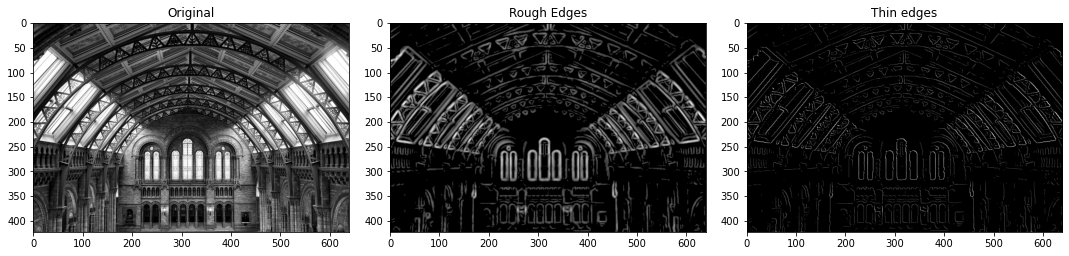

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.tight_layout(pad=1.0)

axes[0].imshow(museum, cmap='gray')
axes[0].set_title('Original')

axes[1].imshow(museum_edges, cmap='gray')
axes[1].set_title('Rough Edges')

axes[2].imshow(museum_thin_edges, cmap='gray')
axes[2].set_title('Thin edges')

#### C

In [23]:
def hysteresis(thin_edges, thigh):
    edges = thin_edges.copy()
    # discard between and not connected to high
    mask = thin_edges.copy()
    mask[mask > 0] = 1
    mask = mask.astype(np.uint8)
    components, labels  = cv2.connectedComponents(mask, connectivity=4)
    for i in range(1, components):
        if np.max(thin_edges[labels == i]) > thigh:
            continue
        edges[labels == i] = 0

    return edges

In [24]:
museum_hysteresis_edges = hysteresis(magnitude_edges_nms(museum_mag, museum_angles, 0.04), 0.08)

Text(0.5, 1.0, 'Hysteresis')

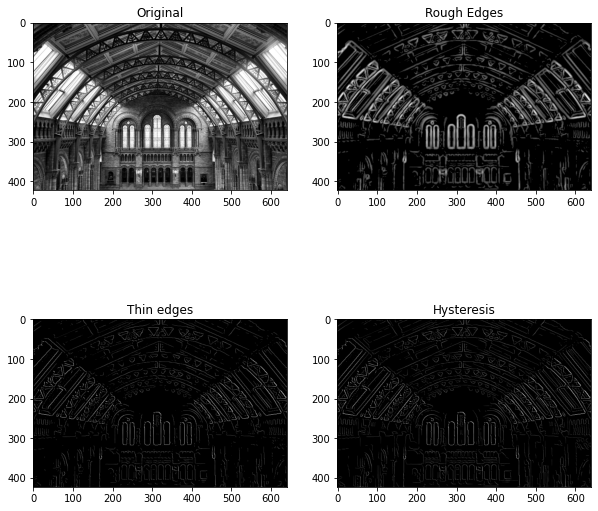

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].imshow(museum, cmap='gray')
axes[0, 0].set_title('Original')

axes[0, 1].imshow(museum_edges, cmap='gray')
axes[0, 1].set_title('Rough Edges')

axes[1, 0].imshow(museum_thin_edges, cmap='gray')
axes[1, 0].set_title('Thin edges')

axes[1, 1].imshow(museum_hysteresis_edges, cmap='gray')
axes[1, 1].set_title('Hysteresis')

### Exercise 3

#### A

Points (0, 0), (1, 1), (1, 0), (2, 2) <br>

y = m * x + c <br>
<br>
y1 = m * x1 + c <br>
y2 = m * x2 + c <br>

m = (y1 - y2) / (x1 - x2) <br>
y1 = x1 * (y1 - y2) / (x1 - x2) + c <br>
c = (x1 * y2 - x2 * y1) / (x1 - x2) <br>
 
(0, 0) (1, 1)
- m = 1
- c = 0

(1, 1) (1, 0) -> vertikalna premica
- m = // ne moremo definirati z y = x * m + c

(1, 0) (2, 2)
- m = 2
- c = -2

In [26]:
fbins, pbins = 300, 300

In [27]:
def angles(size):
    return np.linspace(-np.pi/2, np.pi/2, size)

def img_diagonal(I):
    return np.sqrt(I.shape[0]**2 + I.shape[1]**2)

def add_lines(A, diagonal, angles_domain, x, y):
    for fi in range(len(angles_domain)):
        f = angles_domain[fi]
        p = x * np.cos(f) + y * np.sin(f)
        pi = int(((p + diagonal) / (2*diagonal)) * A.shape[0])

        if pi == A.shape[0]:
            print("warning: pi == A.shape[0]")
            pi -= 1
        A[pi, fi] += 1


In [28]:
angles_domain = angles(fbins)

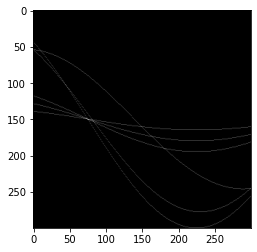

In [29]:
A = np.zeros((fbins, pbins))
diagonal = np.sqrt(2 * 100**2)

add_lines(A, diagonal, angles_domain, 10, 10)
plt.imshow(A, cmap="gray")

add_lines(A, diagonal, angles_domain, 20, 20)
plt.imshow(A, cmap="gray")

add_lines(A, diagonal, angles_domain, 30, 30)
plt.imshow(A, cmap="gray")

add_lines(A, diagonal, angles_domain, 80, 90)
plt.imshow(A, cmap="gray")

add_lines(A, diagonal, angles_domain, 10, 90)
plt.imshow(A, cmap="gray")

add_lines(A, diagonal, angles_domain, 100, 100)
plt.imshow(A, cmap="gray")

#### B

In [30]:
def hug_find_lines(I, f_bins, p_bins, angles_domain):
    diagonal = np.sqrt(I.shape[0]**2 + I.shape[1]**2)
    A = np.zeros((p_bins, f_bins))
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            if I[i, j] == 0:
                continue
            add_lines(A, diagonal, angles_domain, j, i)
    return A

Text(0.5, 1.0, 'Hough')

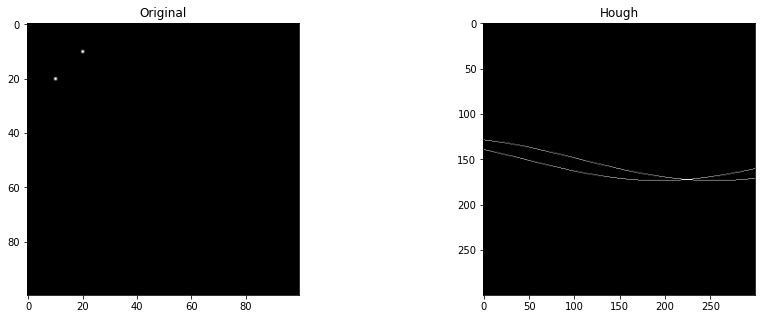

In [31]:
image = np.zeros((100, 100))
# points (a, b) (c, d)
a = 10
b = 20
c = 20
d = 10
image[(a, b), (c, d)] = 1

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original')

line_votes = hug_find_lines(image, fbins, pbins, angles_domain)
axes[1].imshow(line_votes, cmap='gray')
axes[1].set_title('Hough')

In [32]:
oneline = readGrayF64('./assigments/assigment3/images/oneline.png')
rectangle = readGrayF64('./assigments/assigment3/images/rectangle.png')

In [33]:
oneline_mag, oneline_angles = gradient_magnitude(oneline)
rectangle_mag, rectangle_angles = gradient_magnitude(rectangle)

In [99]:
two_points = np.zeros((100, 100))
two_points[10, 10] = 1
two_points[20, 10] = 1

In [100]:
two_points_edges = two_points
oneline_edges = magnitude_edges_nms(oneline_mag, oneline_angles, 0.1)
rectangle_edges = magnitude_edges_nms(rectangle_mag, rectangle_angles, 0.1)

oneline_votes = hug_find_lines(oneline_edges, fbins, pbins, angles_domain)
rectangle_votes = hug_find_lines(rectangle_edges, fbins, pbins, angles_domain)
two_points_votes = hug_find_lines(two_points_edges, fbins, pbins, angles_domain)

Text(0.5, 1.0, 'Hough')

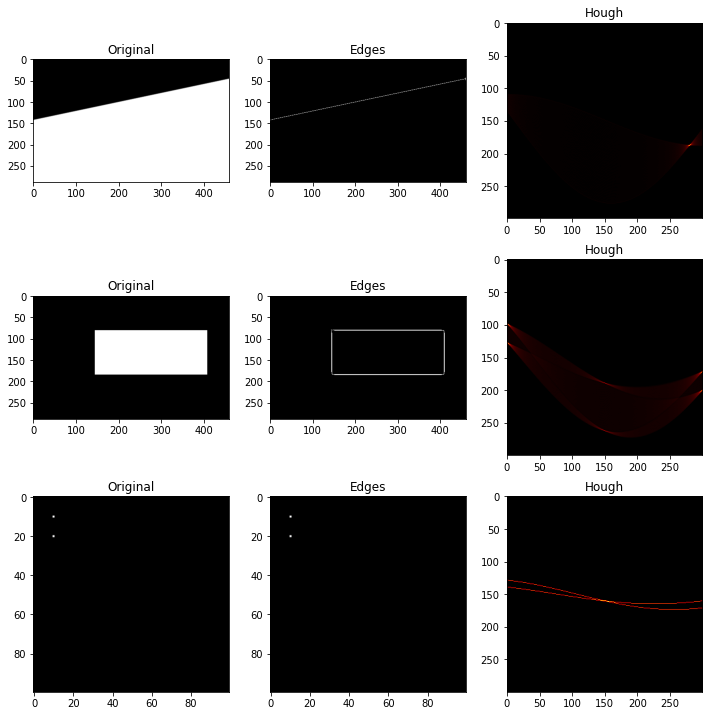

In [101]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
fig.tight_layout(pad=1.0)

axes[0, 0].imshow(oneline, cmap='gray')
axes[0, 0].set_title('Original')

axes[0, 1].imshow(oneline_edges, cmap='gray')
axes[0, 1].set_title('Edges')

axes[0, 2].imshow(oneline_votes, cmap='afmhot')
axes[0, 2] .set_title('Hough')

axes[1, 0].imshow(rectangle, cmap='gray')
axes[1, 0].set_title('Original')

axes[1, 1].imshow(rectangle_edges, cmap='gray')
axes[1, 1].set_title('Edges')

axes[1, 2].imshow(rectangle_votes, cmap='afmhot')
axes[1, 2].set_title('Hough')

axes[2, 0].imshow(two_points, cmap='gray')
axes[2, 0].set_title('Original')

axes[2, 1].imshow(two_points_edges, cmap='gray')
axes[2, 1].set_title('Edges')

axes[2, 2].imshow(two_points_votes, cmap='afmhot')
axes[2, 2].set_title('Hough')

#### C

In [37]:
def non_maxima_suppression_8n(I):
    Is = I.copy()
    for i in range(Is.shape[0]):
        for j in range(Is.shape[1]):
            if Is[i, j] == 0:
                continue
            neighbourhood = Is[max(0, i-1): min(i+2, Is.shape[0]), max(0, j-1): min(j+2, Is.shape[1])]
            neighbourhood_max = neighbourhood.max()
            neighbourhood_max_count = np.count_nonzero(neighbourhood == neighbourhood_max)

            # in place setting to zero keeps only one maximum
            if Is[i, j] < neighbourhood_max or (Is[i, j] == neighbourhood_max and neighbourhood_max_count > 1):
                Is[i, j] = 0
    return Is

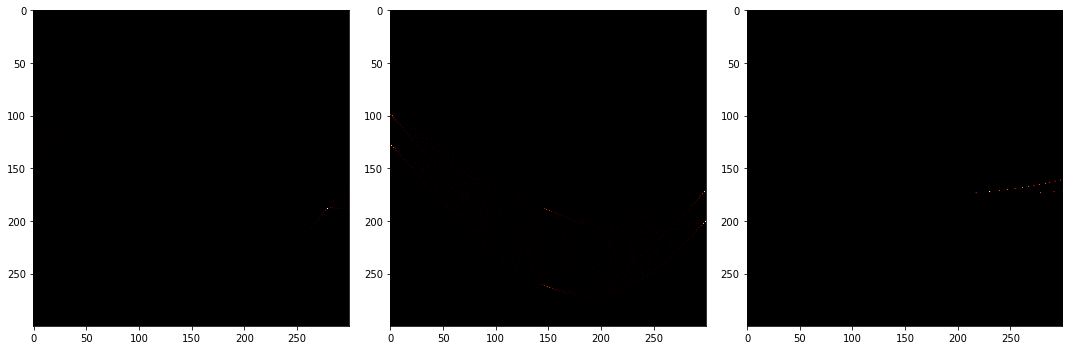

In [38]:
two_points_votes_s = non_maxima_suppression_8n(two_points_votes)
oneline_votes_s = non_maxima_suppression_8n(oneline_votes)
rectangle_votes_s = non_maxima_suppression_8n(rectangle_votes)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.tight_layout(pad=1.0)

axes[0].imshow(oneline_votes_s, cmap='afmhot')

axes[1].imshow(rectangle_votes_s, cmap='afmhot')

axes[2].imshow(two_points_votes_s, cmap='afmhot')

#### D

In [39]:
def extract_lines(I_votes, treshold, angles_domain, diagonal):
    params = []
    for p_idx, a_idx in np.argwhere(I_votes >= treshold):
        # Reverse pi = int(((p + diagonal) / (2*diagonal)) * A.shape[0]) 
        p = (p_idx / I_votes.shape[0]) * (2*diagonal) - diagonal
        a = angles_domain[a_idx]
        params.append((p, a))
    return params

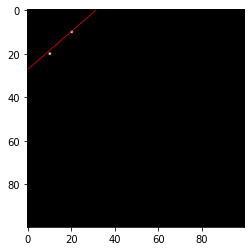

In [40]:
two_points_params = extract_lines(two_points_votes_s, 2, angles_domain, img_diagonal(two_points))
plt.imshow(two_points, cmap='gray')
for p, a in two_points_params:
    draw_line(p, a, two_points.shape[0], two_points.shape[1])

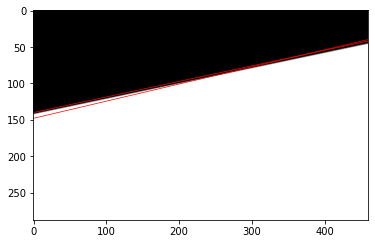

In [41]:
oneline_params = extract_lines(oneline_votes_s, 100, angles_domain, img_diagonal(oneline))
plt.imshow(oneline, cmap='gray')
for p, a in oneline_params:
    draw_line(p, a, oneline.shape[0], oneline.shape[1])

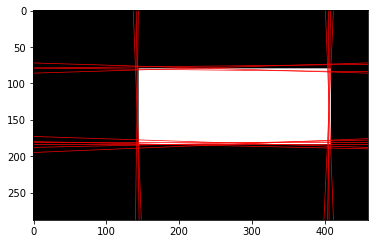

In [42]:
rectangle_params = extract_lines(rectangle_votes_s, 150, angles_domain, img_diagonal(rectangle))
plt.imshow(rectangle, cmap='gray')
for p, a in rectangle_params:
    draw_line(p, a, rectangle.shape[0], rectangle.shape[1])

#### E

In [43]:
bricks = readGrayF64('./assigments/assigment3/images/bricks.jpg')
pier = readGrayF64('./assigments/assigment3/images/pier.jpg')
print(bricks.shape, pier.shape)

(426, 640) (426, 640)


In [44]:
bricks_mag, bricks_grad = gradient_magnitude(bricks)
pier_mag, pier_grad = gradient_magnitude(pier)

In [45]:
bricks_mag_nms = magnitude_edges_nms(bricks_mag, bricks_grad, theta)
peir_mag_nms = magnitude_edges_nms(pier_mag, pier_grad, theta)

In [46]:
bricks_votes = hug_find_lines(bricks_mag_nms, fbins, pbins, angles_domain)
pier_votes = hug_find_lines(peir_mag_nms, fbins, pbins, angles_domain)

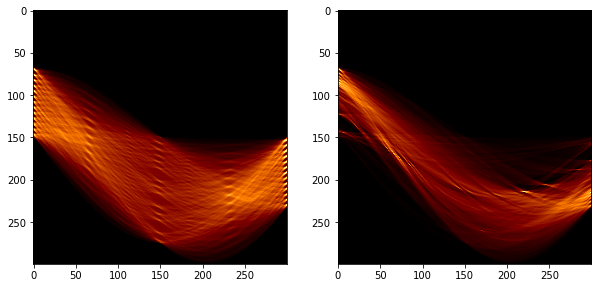

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(bricks_votes, cmap='afmhot')

axes[1].imshow(pier_votes, cmap='afmhot')

In [48]:
bricks_votes_s = non_maxima_suppression_8n(bricks_votes)
pier_votes_s = non_maxima_suppression_8n(pier_votes)

In [49]:
bricks_votes_top10 = np.zeros_like(bricks_votes_s)
bricks_votes_top10[np.unravel_index(np.argpartition(bricks_votes_s.ravel(), -10)[-10:], bricks_votes_top10.shape)] = 1

pier_votes_top10 = np.zeros_like(pier_votes_s)
pier_votes_top10[np.unravel_index(np.argpartition(pier_votes_s.ravel(), -10)[-10:], pier_votes_top10.shape)] = 1

In [50]:
bricks_10_lines = extract_lines(bricks_votes_top10, 1, angles_domain, img_diagonal(bricks))
pier_10_lines = extract_lines(pier_votes_top10, 1, angles_domain, img_diagonal(pier))

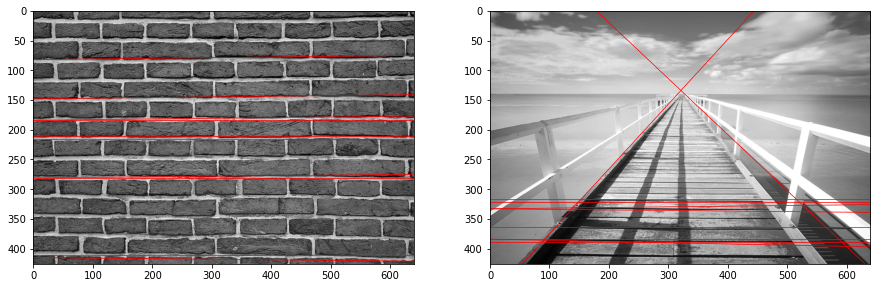

In [51]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1).imshow(bricks, cmap='gray')
for p, a in bricks_10_lines:
    draw_line(p, a, bricks.shape[0], bricks.shape[1])

plt.subplot(1, 2, 2).imshow(pier, cmap='gray')
for p, a in pier_10_lines:
    draw_line(p, a, pier.shape[0], pier.shape[1])

#### F

In [149]:
def hug_find_lines_with_grad(Imag, Igrad, f_bins, p_bins):
    diagonal = np.sqrt(Imag.shape[0]**2 + Imag.shape[1]**2)
    A = np.zeros((p_bins, f_bins))
    for y in range(Imag.shape[0]):
        for x in range(Imag.shape[1]):
            if Imag[y, x] <= 0.1:
                continue
            # use only one angle
            f = Igrad[y, x]
            # second quadrant to fourth quadrant
            if f > np.pi/2:
                f -= np.pi
            # thrid quadrant to first quadrant
            if f < -np.pi/2:
                f += np.pi
                
            fi = int(((f + np.pi/2) / np.pi) * f_bins)

            # calculate p
            p = x * np.cos(f) + y * np.sin(f)
            pi = int(((p + diagonal) / (2*diagonal)) * p_bins)

            if pi == p_bins:
                print("warning: pi == p_bins")
                pi -= 1
            
            A[pi, min(fi, A.shape[1] -1)] += 1
    return A

In [150]:
oneline_hug_single_vote = hug_find_lines_with_grad(oneline_edges, oneline_angles, fbins, pbins)

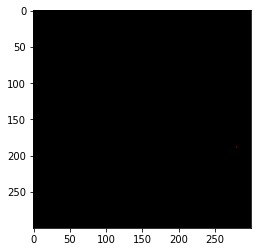

In [139]:
plt.imshow(oneline_hug_single_vote, cmap='afmhot')

In [114]:
oneline_hug_single_vote_s = non_maxima_suppression_8n(oneline_hug_single_vote)

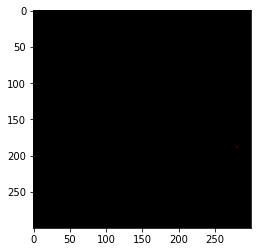

In [115]:
plt.imshow(oneline_hug_single_vote_s, cmap='afmhot')

In [152]:
one_line_top_lines = extract_lines(oneline_hug_single_vote_s, 100, angles_domain, img_diagonal(oneline))
print(one_line_top_lines)

[(137.48883364760127, 1.3711633488075852)]


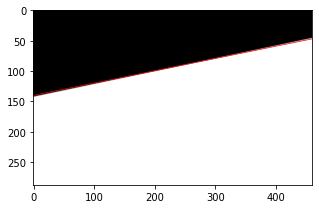

In [151]:
plt.figure(figsize=(5, 5))

plt.subplot(1, 1, 1).imshow(oneline, cmap='gray')
for p, a in one_line_top_lines:
    draw_line(p, a, oneline.shape[0], oneline.shape[1])


#### F*

In [153]:
def get_fast_lines(I, mag_theta, f_bins, p_bins, lines):
    angles_domain = angles(f_bins)
    I_mag, I_grad = gradient_magnitude(I)
    I_mag_nms = magnitude_edges_nms(I_mag, I_grad, mag_theta)
    votes = hug_find_lines_with_grad(I_mag_nms, I_grad, f_bins, p_bins)
    votes_s = non_maxima_suppression_8n(votes)
    n_lines = np.partition(votes_s.flatten(), -lines)[-lines]
    return extract_lines(votes_s, n_lines, angles_domain, img_diagonal(I))

In [176]:
oneline = readGrayF64('./assigments/assigment3/images/oneline.png')
rect = readGrayF64('./assigments/assigment3/images/rectangle.png')
bricks = readGrayF64('./assigments/assigment3/images/bricks.jpg')
pier = readGrayF64('./assigments/assigment3/images/pier.jpg')

In [177]:
oneline_mag, oneline_angles = gradient_magnitude(oneline)
rect_mag, rect_angles = gradient_magnitude(rect)
bricks_mag, bricks_angles = gradient_magnitude(bricks)
pier_mag, pier_angles = gradient_magnitude(pier)

In [156]:
fbins, pbins = 300, 300
theta = 0.08

In [159]:
oneline_lines = get_fast_lines(oneline_mag, theta, fbins, pbins, 1)

In [162]:
rect_lines = get_fast_lines(rect_mag, theta, fbins, pbins, 8)

In [173]:
bricks_lines = get_fast_lines(bricks_mag, theta, fbins, pbins, 5)

In [180]:
pier_lines = get_fast_lines(pier_mag, theta, fbins, pbins, 5)

In [125]:
def draw_with_lines(I, lines):
    plt.imshow(I, cmap='gray')
    for p, a in lines:
        draw_line(p, a, I.shape[0], I.shape[1])

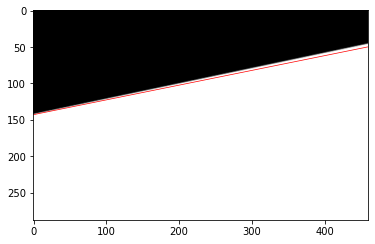

In [160]:
draw_with_lines(oneline, oneline_lines)

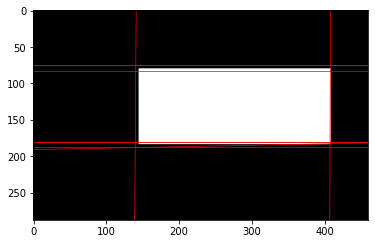

In [175]:
draw_with_lines(rect, rect_lines)

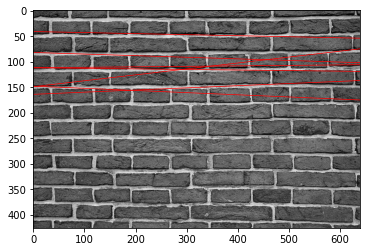

In [174]:
draw_with_lines(bricks, bricks_lines)

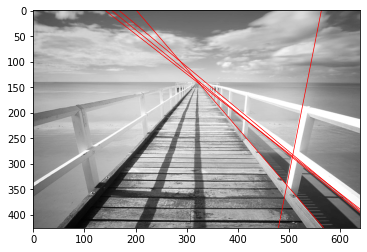

In [181]:
draw_with_lines(pier, pier_lines)

#### G

In [71]:
def vote_for_circle(Imag, thresh, angle_step, r):
    votes = np.zeros((Imag.shape[0], Imag.shape[1]))
    for y in range(Imag.shape[0]):
        for x in range(Imag.shape[1]):
            if Imag[y, x] <= thresh:
                continue
            for theta in np.arange(0, 2*np.pi, angle_step):
                a = int(x + r * np.cos(theta))
                b = int(y + r * np.sin(theta))
                if a < 0 or a >= Imag.shape[1]:
                    continue
                if b < 0 or b >= Imag.shape[0]:
                    continue
                votes[b, a] += 1
    return votes

def extract_circle(votes, threshold):
    circles = []
    for y in range(votes.shape[0]):
        for x in range(votes.shape[1]):
            if votes[y, x] >= threshold:
                circles.append((x, y))
    return circles

def draw_circle(x, y, r):
    circle = plt.Circle((x, y), r, color='g', fill=False, linewidth=2)
    plt.gca().add_patch(circle)

In [72]:
eclipse = readGrayF64('./assigments/assigment3/images/eclipse.jpg')
print(eclipse.shape)

(473, 709)


In [73]:
eclipse_mag, eclipse_grad = gradient_magnitude(eclipse)
eclipse_mag = magnitude_edges_nms(eclipse_mag, eclipse_grad, 0.06)

In [74]:
radius = 45

In [75]:
eclipse_votes = vote_for_circle(eclipse_mag, 0.05, np.pi/180, radius)

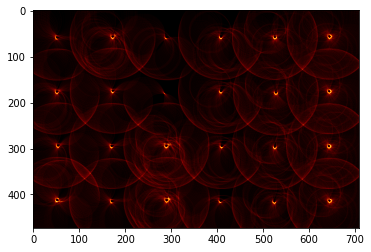

In [76]:
plt.imshow(eclipse_votes, cmap='afmhot')

In [77]:
eclipse_votes_s = non_maxima_suppression_8n(eclipse_votes)

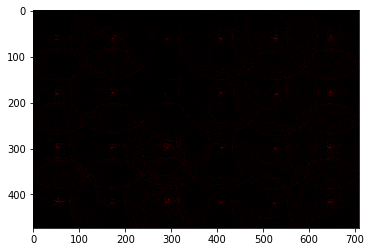

In [78]:
plt.imshow(eclipse_votes_s, cmap='afmhot')

In [79]:
circle_params = extract_circle(eclipse_votes_s, eclipse_votes_s.max() * 0.5)
len(circle_params)

95

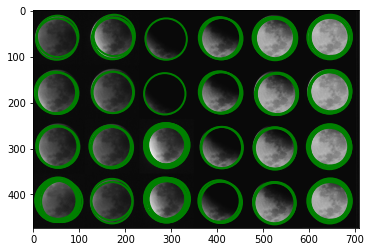

In [80]:
plt.imshow(eclipse, cmap='gray')
for x, y in circle_params:
    draw_circle(x, y, radius)

#### H

In [81]:
def limit_to_interval(x, a, b):
    return max(a, min(x, b))

line_lengths = set()
def line_length(f, p, I_shape):
    height, width = I_shape
    # line is vertical
    if f == 0:
        width = 0
    # line is horizontal
    elif abs(f) == np.pi/2:
        height = 0
    else:
        x_min = limit_to_interval(p / np.cos(f), 0, width)
        x_max = limit_to_interval((p - height * np.sin(f)) / np.cos(f), 0, width)

        y_min = limit_to_interval(p / np.sin(f), 0, height)
        y_max = limit_to_interval((p - width * np.cos(f)) / np.sin(f), 0, height)

        width = abs(x_max - x_min)
        height = abs(y_max - y_min)
    line_lengths.add(round(np.sqrt(width**2 + height**2), 3))
    return np.sqrt(height**2 + width**2)

def the_hough(magnitude, angle, magnitude_th, pbins, fbins):
    # reduce angle to [-pi/2, pi/2]
    angle[angle > np.pi/2] -= np.pi
    angle[angle < -np.pi/2] += np.pi

    # get the max length of the line
    diagonal = np.sqrt(magnitude.shape[0]**2 + magnitude.shape[1]**2)

    votes = np.zeros((pbins, fbins))
    for y in range(magnitude.shape[0]):
        for x in range(magnitude.shape[1]):
            if magnitude[y, x] <= magnitude_th:
                continue
            # angle
            f = angle[y, x]
            fi = int(((f + np.pi/2) / np.pi) * fbins)
            # offset
            p = x * np.cos(f) + y * np.sin(f)
            pi = int(((p + diagonal) / (2*diagonal)) * pbins)
            votes[pi, min(fi, votes.shape[1] -1)] += 1 / max(line_length(f, p, magnitude.shape), 1)
    return votes


41.42135623730949

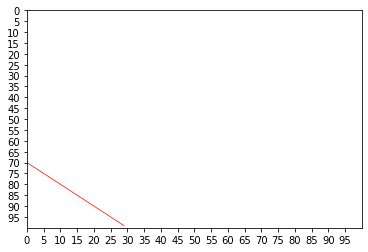

In [82]:
# testing line length
p = -50
f = -np.pi/4
draw_line(p, f, 100, 100)
plt.xlim(0, 100)
plt.xticks(np.arange(0, 100, 5))
plt.ylim(100, 0)
plt.yticks(np.arange(0, 100, 5))
line_length(f, p, (100, 100))

In [83]:
votes = the_hough(pier_mag, pier_grad, 0.05, 300, 300)

In [84]:
votes.max(), votes.min(), votes.mean()

(0.3319548972230892, 0.0, 0.0013311141018475005)

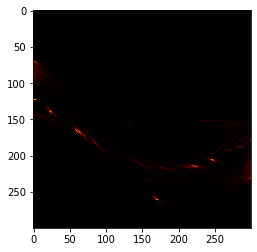

In [85]:
plt.imshow(votes, cmap='afmhot')

In [86]:
votes_s = non_maxima_suppression_8n(votes)

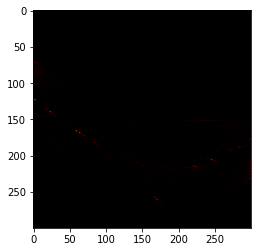

In [87]:
plt.imshow(votes_s, cmap='afmhot')

In [88]:
lines = extract_lines(votes_s, votes_s.max() * 0.5, angles_domain, img_diagonal(pier))
len(lines)

13

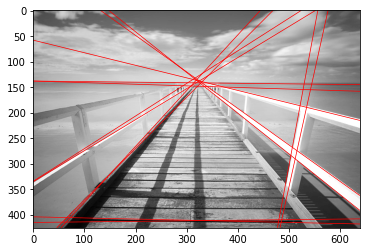

In [89]:
draw_with_lines(pier, lines)

In [90]:
def draw_the_hough(I, fbins, pbins, th, lines):
    angles_domain = angles(fbins)
    mag, grad = gradient_magnitude(I)
    votes = the_hough(mag, grad, th, fbins, pbins)
    votes_s = non_maxima_suppression_8n(votes)
    n_lines = np.partition(votes_s.flatten(), -lines)[-lines]
    lines = extract_lines(votes_s, n_lines, angles_domain, img_diagonal(I))
    draw_with_lines(I, lines)


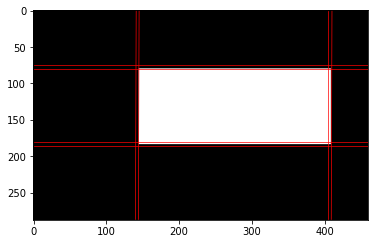

In [91]:
draw_the_hough(rectangle, 500, 500, 0.05, 8)

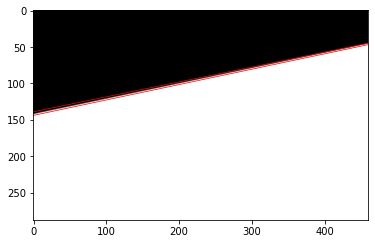

In [92]:
draw_the_hough(oneline, 500, 500, 0.05, 2)

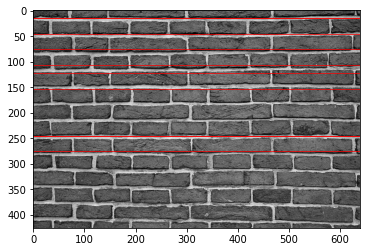

In [93]:
draw_the_hough(bricks, 100, 100, 0.08, 10)

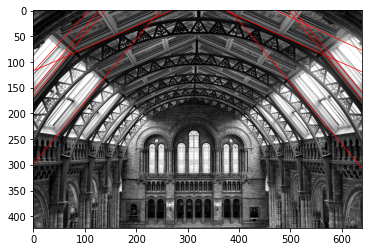

In [94]:
draw_the_hough(museum, 500, 500, 0.08, 10)

example of improvmed of the_hough vs fast_get_lines

In [95]:
l_s_lines = readGrayF64('./assigments/assigment3/images/long_short_lines.png')
l_s_lines.shape

(300, 300)

In [96]:
theta = 0.08
fbins = 300
pbins = 300
num_lines = 1

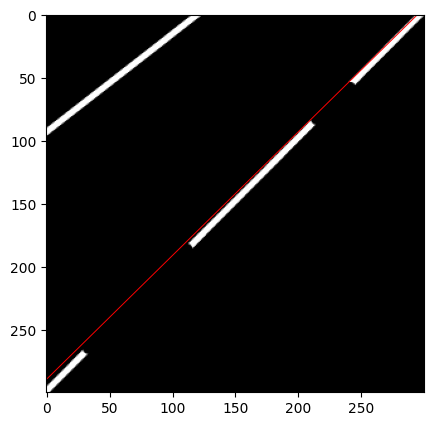

In [97]:
l_s_lines_votes = get_fast_lines(l_s_lines, theta, fbins, pbins, num_lines)
plt.figure(figsize=(5, 5), dpi=100)
draw_with_lines(l_s_lines, l_s_lines_votes)

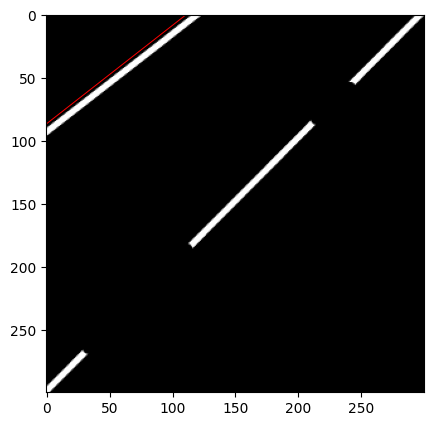

In [98]:
plt.figure(figsize=(5, 5), dpi=100)
draw_the_hough(l_s_lines, fbins, pbins, theta, num_lines)

as we can adjusted algorithem correctly select more certain line, while the older one prefferes longer dashed line